In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/real_vs_fake_detection/

/gdrive/MyDrive/real_vs_fake_detection


In [4]:
ls

training_fake/  training_real/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [7]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=15
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/real_vs_fake_detection",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1617 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
class_names

['training_fake', 'training_real']

In [10]:
len(dataset)

27

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[ 83.65625   92.328125  76.19971 ]
  [ 85.72388   94.703125  77.10425 ]
  [ 88.32959   92.95459   79.091064]
  ...
  [ 60.563965  72.563965  26.563965]
  [ 63.656494  75.656494  29.656494]
  [ 67.22046   79.22046   33.22046 ]]

 [[ 80.677     93.677     75.677   ]
  [ 88.06201  100.031006  88.12427 ]
  [ 81.55127   89.55127   74.95752 ]
  ...
  [ 63.901855  75.901855  29.901855]
  [ 66.99951   78.99951   32.99951 ]
  [ 69.671875  81.671875  35.671875]]

 [[ 84.03125   95.984375  81.282715]
  [ 88.9563   100.576904  87.180664]
  [ 69.2229    77.09375   61.6062  ]
  ...
  [ 62.640625  74.640625  28.640625]
  [ 66.61499   78.61499   32.61499 ]
  [ 70.296875  82.296875  36.296875]]

 ...

 [[ 67.241455  44.241455  10.241455]
  [ 70.410645  47.410645  13.410645]
  [ 76.28125   53.28125   19.28125 ]
  ...
  [124.79785  101.71973   62.36035 ]
  [120.328125 100.25      60.598145]
  [109.08667   86.85083   47.96875 ]]

 [[ 70.27612   47.276123  13.276123]
  [ 75.0

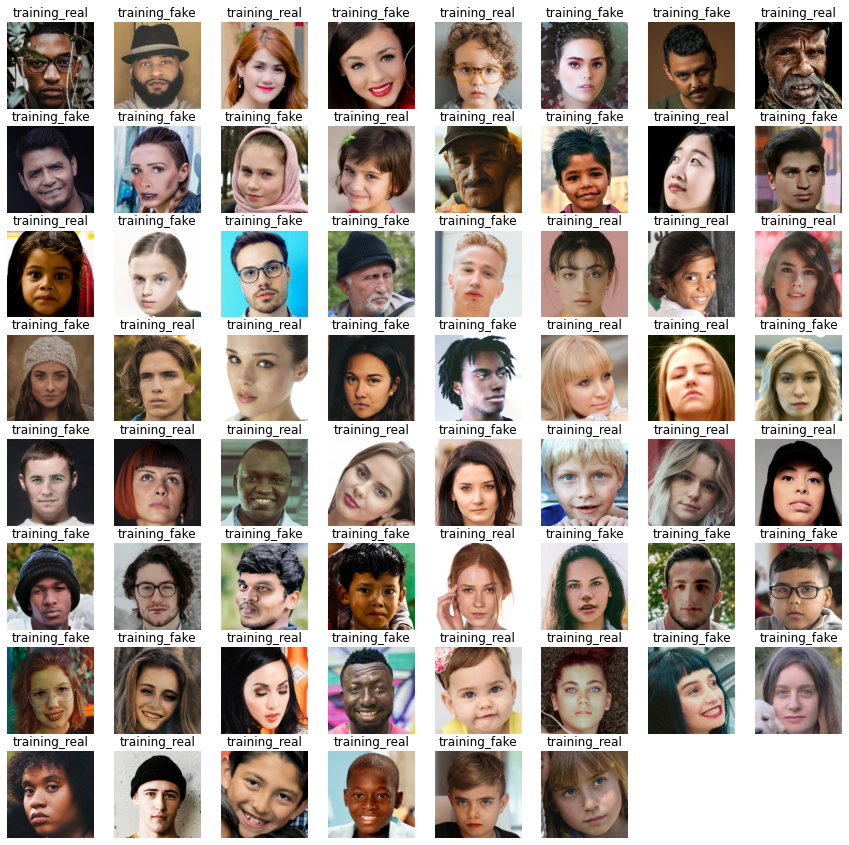

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/15
21/21 [==============================] - 136s 7s/step - loss: 0.6476 - accuracy: 0.6217 - val_loss: 0.6578 - val_accuracy: 0.6129
Epoch 2/15
21/21 [==============================] - 139s 7s/step - loss: 0.5904 - accuracy: 0.6876 - val_loss: 0.6642 - val_accuracy: 0.6129
Epoch 3/15
21/21 [==============================] - 136s 6s/step - loss: 0.5771 - accuracy: 0.7036 - val_loss: 0.6476 - val_accuracy: 0.6452
Epoch 4/15
21/21 [==============================] - 135s 6s/step - loss: 0.5925 - accuracy: 0.6908 - val_loss: 0.6706 - val_accuracy: 0.6048
Epoch 5/15
21/21 [==============================] - 135s 6s/step - loss: 0.5642 - accuracy: 0.7092 - val_loss: 0.6550 - val_accuracy: 0.6210
Epoch 6/15
21/21 [==============================] - 135s 6s/step - loss: 0.5222 - accuracy: 0.7486 - val_loss: 0.6068 - val_accuracy: 0.6532
Epoch 7/15
21/21 [==============================] - 135s 6s/step - loss: 0.4752 - accuracy: 0.7639 - val_loss: 0.6570 - val_accuracy: 0.7177
Epoch 8/15
21

In [22]:
model.evaluate(test_ds)

4/4 [==============================] - 19s 1s/step - loss: 0.4369 - accuracy: 0.8377


[0.4368947744369507, 0.8376963138580322]

In [23]:
acc = history.history['accuracy']
loss = history.history['loss']

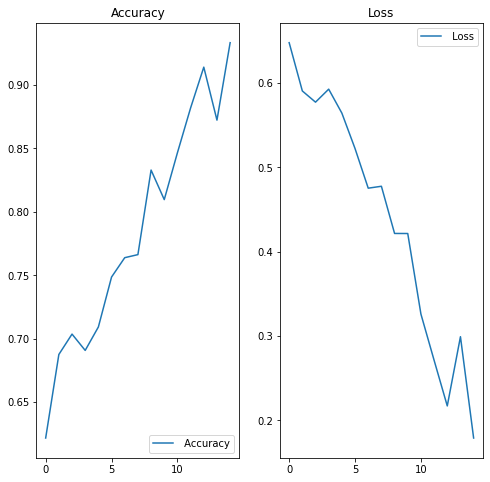

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

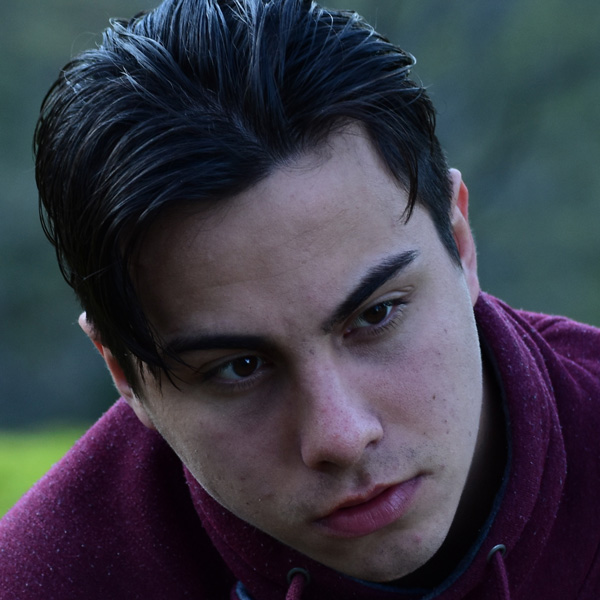

In [25]:
image_path = "/gdrive/My Drive/real.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [26]:
pred = model.predict(scaled_img)

In [27]:
output = class_names[np.argmax(pred)]

In [28]:
output

'training_real'

In [29]:
model.save("real_vs_fake_detection.h5")